In [1]:
# Some basic imports before we start
import numpy as np
import matplotlib.pyplot as plt
import torch

This tutorial is meant to explain how to understand the components of this library, so using them later is clearer. As such, we're not trying to showcase a particular application. For that, refer to "Train flows - X.ipynb" where we train and sample from a flow for different datasets.

This notebook contains basic explanations about the architecture of the library, about the Conditioner-Transformer framework and how it applies to our flows, and about where each component is located inside the package.

# Basic architectural concepts

A Normalizing Flow can be understood as an invertible function $f$ (actually, a diffeomorphism) between two real spaces affected by probability distributions, X and U. X is the *data distribution*, the distribution of our data points (our dataset) and U is the *base distribution*, or *prior*, the simple distribution we use as an anchor, normally a multivariate standard Normal distribution. 

When we talk about Flows we refer to the functions $U = f(X)$, meaning, we go from X to U. When doing the opposite transformation, we talk about the inverted flow, $X = f^{-1}(U)$.

A Flow is a torch.nn.Module that can perform 4 different operations:

* **transform**: transforms samples from X into samples from U.
* **invert**: transforms samples from U into samples from X.
* **nll**: computes the Negative Log-Likelihood of the given samples from X. 
    We use the *negative* log-likelihood because it can be used directly as a loss function
    for the training of flows (our objective is to maximize dataset likelihood, 
    which is equivalent as minimizing its log-likelihood).
* **sample**: generates samples from X. This is done by sampling points from U and inverting them to X.

Flow is an abstract class that can be found in flow.flow (flow root package, flow module). NOTE: All important components found in flow.flow can be accessed directly through the package itself:

In [2]:
# There imports are actually located inside flow.flow.
# They act as shortcuts
from flow import Flow, Sequential, Conditioner, Transformer, inv_flow

Flow is an abstract class. It doesn't do anything by itself. If you want to define your own flow, you can either define it completely by inheriting from Flow or, instead, use the Conditioner-Transformer framework, as we'll describe later.

Let's start by instancing our first flow. There are vanilla flows implemented inside the *modules* submodule.

In [3]:
from flow.modules import Affine, Sigmoid, BatchNorm

In [4]:
# For this example, we'll create an affine Flow providing it base values for its parameters.
# Normally, we don't need to do this.
weight = torch.ones(1, 1) * 5. # shape of weight should be (1, dim)
bias = torch.ones(1, 1) * 10 # shape of bias should be (1, dim)

flow = Affine(weight=weight, bias=bias, dim=1) # dim=1 is optional; dim defaults to 1
# This applies the affine transformation: u = x * weight + bias

Let's try transforming back and forth:

(0.080238625, 1.0488305, 10.401194, 5.2441525)

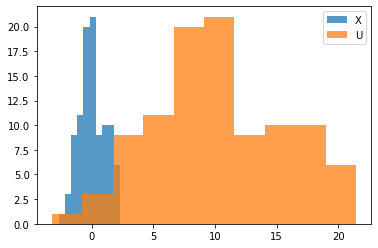

In [5]:
X = torch.randn(100, 1) # let's define samples from X
with torch.no_grad(): # we don't want to train now, so we don't need grad
    U = flow(X) # this transforms X into U

# Let's plot them
X = X.numpy().flatten() # don't forget the trailing second dimension
U = U.numpy().flatten()

plt.hist(X, color='C0', alpha=.75, label='X')
plt.hist(U, color='C1', alpha=.75, label='U')

plt.legend()

X.mean(), X.std(), U.mean(), U.std() # let's see how we move from (0, 1) to (10, 5)

(0.080238625, 1.0488306, 10.401194, 5.2441525)

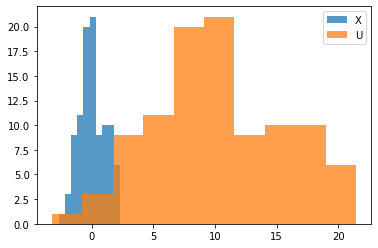

In [6]:
# Let's use the previous U samples and transform them back to X

U = torch.Tensor(U).unsqueeze(1) # remember to transform back to tensor with 2 dimensions
with torch.no_grad(): # again, we don't need grad now
    X2 = flow(U, invert=True) # to invert, pass invert=True

# Let's plot them
X2 = X2.numpy().flatten()
U = U.numpy().flatten()

plt.hist(X2, color='C0', alpha=.75, label='X')
plt.hist(U, color='C1', alpha=.75, label='U')

plt.legend()

X2.mean(), X2.std(), U.mean(), U.std()

As expected, we get the same result.

Let's try the two other functionalities.

In [7]:
# In order to sample, call flow.sample
with torch.no_grad(): 
    sample = flow.sample(1000)
    
# sample generates new samples from the base distribution
# and inverts them back to X.
# If we don't specify another base distribution (or prior in the terminology of the library)
# we'll generate standard multivariate normal samples.
# So, mean 0 and std 1. By inverting from there using weight 5 and bias 10,
# we now expect, in X, mean -2, std 0.2

sample = sample.numpy().flatten()

sample.mean(), sample.std()

(-2.0012968, 0.20028135)

In [8]:
# And we can compute negative log-likelihoods of X too
sample = torch.Tensor(sample).unsqueeze(1)

with torch.no_grad():
    nll = flow.nll(sample)
    
nll[:5]

tensor([-0.2853, -0.3713, -0.6898, -0.6870, -0.6902])

# Conditioner-Transformer

When we're dealing with multivariate distributions, Conditioners help.

Look at https://arxiv.org/abs/1912.02762 for an introduction to the Conditioner-Transformer framework.

Basically, a Transformer performs a differentiable operation given some parameters (loc and scale in the previous example), while a Conditioner generates values for these parameters using a learnable network. This network can be an autoregressive function (each dimension function depends on the previous dimension's values). 

This library, although it allows the definition of flows directly, encourages their definition as the combination of a Conditioner module and a Transformer module. By modularizing these two parts, we can create new flows by mixing the best conditioners with the best transformers directly, without having to reimplement any of these parts for each new flow.

Conditioner and Tranformer are two abstract classes that can be found in flow.flow (or in flow through relative import as a shortcut, as seen before). You need to inherit from them when defining your own Conditioners/Transformers.

Implementations of these can be found in the submodules conditioner and transformer. For the following example, we will work with Masked Autoregressive flow for Density Estimation ([MADE](http://papers.nips.cc/paper/6828-masked-autoregressive-flow-for-density-estimation)) as a Conditioner, and an Affine transformer as the Transformer.

# Training a flow

Now, all of this only makes sense if we've trained the Flow first.
For that, we can just use this same .nll function as the training loss.

flow already comes with a training module that includes several training utilities.

In [9]:
from flow.training import train, get_device, plot_losses, test_nll

Let's define first a training exercise and then use it to showcase these 4 functions.

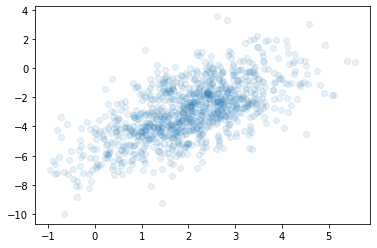

In [10]:
X = torch.randn(1000, 2).matmul(torch.Tensor([[1., .5], [.5, 2.]])) + torch.Tensor([[2, -3.]])

plt.scatter(*X.numpy().T, alpha=.1)

Let's also divide the dataset in 3 splits.

In [11]:
trainX = X[:800]
valX = X[800:900]
testX = X[900:]

Now, we'll define our MADE-Affine flow. To create a Flow as a Conditioner-Transformer, we create the transformer and pass it to the Conditioner directly. The Conditioner acts as a Flow, with the same operations as before.

In [12]:
from flow.conditioner import MADE
from flow.transformer import Affine as AffineTransformer

trnf = AffineTransformer(dim=2) # note that we need to pass dim to the transformer
flow = MADE(trnf)

# or: flow = MADE(AffineTransformer(dim=2))

Let's try to learn from this distribution. To do that, just call train.

Note that train returns training losses and validation losses, that you can plot with plot_losses.

201it [00:17, 11.68it/s, epoch_progress=100%, train_loss=+3.234e+00, last_val_loss=+3.506e+00, best_epoch=191, best_loss=+3.499e+00]


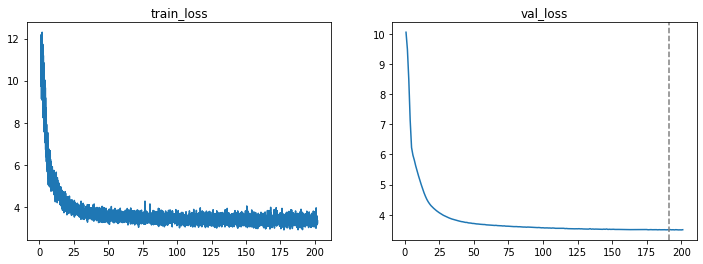

In [13]:
device = get_device() # get the torch device where we're training.
# get_device() returns cuda if it available, or cpu otherwise

flow.to(device) # don't forget to move flow to that device

# Let's start training.
# train will use flow.nll(batch).mean() as the training loss.
# It will also use Early Stopping, which means, 
# it will stop after *patience* iterations if it hasn't improved in validation loss.
train_losses, val_losses = train(flow, trainX, valX, patience=10)

# Finally, let's plot loss evolution with plot_losses
plot_losses(train_losses, val_losses)

In [14]:
# Let's check its results now
test_nll(flow, testX) # computes the average test nll

3.502446621656418

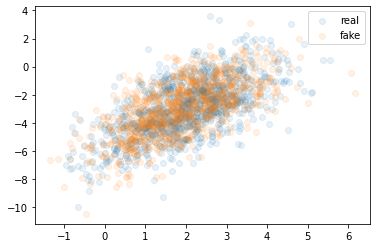

In [15]:
# Plot some samples
with torch.no_grad():
    sample = flow.sample(1000)
    
sample = sample.cpu().numpy()

plt.scatter(*X.numpy().T, alpha=.1, label='real')
plt.scatter(*sample.T, alpha=.1, label='fake')
plt.legend();

# 1-dimensional flows

If you want to learn univariate distributions, and want to take advantage of the implemented transformers, it doesn't make sense to use MADE as the Conditioner. For cases such as these, it's better to work with conditioner.AutoregressiveNaive.

AutoregressiveNaive is a special Conditioner that creates a separate network for each dimension to transform. If we only have 1, it just creates a learnable tensor for the transformer's parameters.

225it [00:07, 30.71it/s, epoch_progress=100%, train_loss=+1.513e+00, last_val_loss=+1.557e+00, best_epoch=215, best_loss=+1.557e+00]


1.5160309746861458

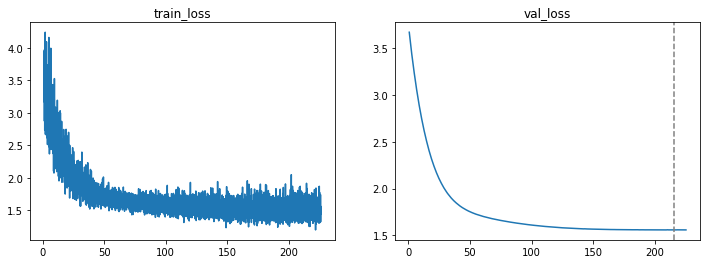

In [16]:
from flow.conditioner import AutoregressiveNaive

flow = AutoregressiveNaive(AffineTransformer()) # if we don't pass dim, it's assumed to be 1

# We'll work with the first component of the previous X dataset
losses = train(flow, trainX[:, [0]], valX[:, [0]], patience=10)
plot_losses(*losses)

test_nll(flow, testX[:, [0]])

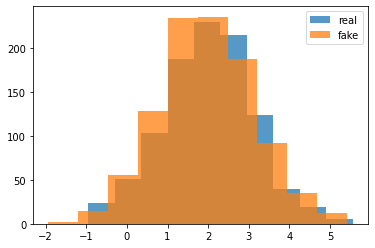

In [17]:
# Plot samples
with torch.no_grad():
    sample = flow.sample(1000).cpu().numpy().flatten()
    
plt.hist(X[:, 0].cpu().numpy(), alpha=.75, label='real')
plt.hist(sample, alpha=.75, label='fake')
plt.legend();

# Available Transformers

For now, flow.transformer contains two different transformers: Affine and DSF.

Affine is a simple affine transformation.

Deep Sigmoidal Flow (https://arxiv.org/abs/1804.00779) performs a powerful non-affine transformation. It's inverse, however, cannot be computed analitically (although it exists and it's differentiable). That means that, when inverting (therefore, also when sampling), we need to use approximate methods to invert tensors. DSF uses the Adam optimizer to do its inversions. 

DSF is really powerful to model distributions, but it's non-differentiable inverse, that is also expensive to compute, is a significant drawback. Use care when choosing your Transformer, so it adapts to your needs.

# Available Conditioners

For now, flow.conditioner contains three different conditioners:

* AutoregressiveNaive: should only be used with very low-dimensional conditioners.
* MADE: recommended for lower-dimensional conditioners, but can be used for big dimensions too. Note that its inversion time is proportional to the number of dimensions.
* CouplingLayers: less powerful than MADE but much faster in forward and backward mode. If used, should be stacked with multiple other CouplingLayers (using Sequential). 

# Other kinds of Flow

As stated before, there are other non-Conditioner-Transformer flows in flow.modules:

* Affine: simple Affine Flow. Note that this is not a Transformer, but a full Flow.
* Sigmoid.
* LogSigmoid.
* Softplus.
* LeakyReLU.
* BatchNorm: Batch Normalization as a flow. Can only be trained in forward-mode (X to U).
* ActNorm: Activation Normalization as a flow, from https://arxiv.org/pdf/1807.03039.pdf
* Shuffle: performs a random (but constant) permutation of the tensor's dimensions. Use in between different flows in a Sequential for more powerful flows.

# Implementing my own flow

For details about how to implement your own flows, refer to the Implementing my own flow tutorial.